In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
!pip install bayesian-optimization
!pip install hdbscan

     |████████████████████████████████| 4.4MB 3.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.25-cp36-cp36m-linux_x86_64.whl size=2361044 sha256=0b529dffd4cadfd79d152885e6c9a72a1aa6e943bae9d8c86b93f0a9dc555290
  Stored in directory: /root/.cache/pip/wheels/9c/c0/c3/233f1760ffcf845291955c8aa53e0a81b695bec07780ee5935
Successfully built hdbscan


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold   
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score
import re
from sklearn.decomposition import PCA
%matplotlib inline
train = pd.read_pickle("/gdrive/My Drive/Data/train.pkl")
test = pd.read_pickle("/gdrive/My Drive/Data/test.pkl")

In [0]:
df = train[['game_id', 'winner', 'player', 'species']]
df = df.drop_duplicates().reset_index(drop=True)
df['win'] = (df['winner'] == df['player'])
df = df.drop(['winner'], axis=1)
game_ids = df['game_id'].unique()

wins  = df.loc[df['win']==True]
loses = df.loc[df['win']==False]

game = {'TvP':0, 'TvZ':0, 'PvT':0, 'PvZ':0, 'ZvT':0, 'ZvP':0,}

for game_id in game_ids:
    win  = wins[wins['game_id']==game_id]['species'].iloc[0]
    lose = loses[loses['game_id']==game_id]['species'].iloc[0]

    if (win == 'T') and (lose == 'P'):
        game['TvP'] += 1
    elif (win == 'T') and (lose == 'Z'):
        game['TvZ'] += 1
        
    elif (win == 'P') and (lose == 'T'):
        game['PvT'] += 1
    elif (win == 'P') and (lose == 'Z'):
        game['PvZ'] += 1
        
    elif (win == 'Z') and (lose == 'T'):
        game['ZvT'] += 1
    elif (win == 'Z') and (lose == 'P'):
        game['ZvP'] += 1
        
    else:
        pass

In [0]:
def win_prop(df):
  game_ids = df['game_id'].unique() 
  win_prop = []
  for game_id in game_ids:
    player0_sp = df[df['game_id']==game_id]['species'].iloc[0]
    player1_sp = df[df['game_id']==game_id]['species'].iloc[1]
    if (player0_sp == player1_sp):
      win_prop.append(0.5)
    elif (player0_sp == 'T') and (player1_sp == 'P'):
      win_prop.append(game['PvT']/(game['TvP']+game['PvT']))
    elif (player0_sp == 'T') and (player1_sp == 'Z'):
     win_prop.append(game['ZvT']/(game['TvZ']+game['ZvT']))
        
    elif (player0_sp == 'P') and (player1_sp == 'T'):
      win_prop.append(game['TvP']/(game['TvP']+game['PvT']))
    elif (player0_sp == 'P') and (player1_sp == 'Z'):
      win_prop.append(game['ZvP']/(game['PvZ']+game['ZvP']))
        
    elif (player0_sp == 'Z') and (player1_sp == 'T'):
      win_prop.append(game['TvZ']/(game['TvZ']+game['ZvT']))
    elif (player0_sp == 'Z') and (player1_sp == 'P'):
      win_prop.append(game['PvZ']/(game['PvZ']+game['ZvP']))
  return pd.Series(win_prop)

def event_process(train,df_train):
  for event in train.event.unique():
    df = train[(train.player==0)&(train.event==event)]
    df = pd.DataFrame(df.game_id.value_counts()[df.game_id.unique()]).rename({'game_id':event+'_count_0'}, axis = 1)
    df['game_id']= np.array(df.index)
    df_train = pd.merge(df_train, df, on='game_id', how='left')

    df = train[(train.player==1)&(train.event==event)]
    df = pd.DataFrame(df.game_id.value_counts()[df.game_id.unique()]).rename({'game_id':event+'_count_1'}, axis = 1)
    df['game_id']= np.array(df.index)
    df_train = pd.merge(df_train, df, on='game_id', how='left')
    
  df_train = df_train.fillna(0)
  for event in train.event.unique():
    df_train[event + '_diff'] = df_train[event+'_count_0'] - df_train[event+'_count_1']
    # df_train.drop([event+'_count_0',event+'_count_1'],axis=1,inplace=True)

    # for event in tqdm(train.event.unique()):
    # df = train[(train.player==0)&(train.event==event)]
    # df["time_tmg"] = df["time"].astype(int)
    # df = df.groupby(["time_tmg","game_id"]).count()["event"].unstack("time_tmg")
    # df.columns = df.columns.astype(str)
    # df.columns = event + df.columns + "_count_0"
    # df_train = df_train.merge(df, on='game_id', how='left')

    # df = train[(train.player==1)&(train.event==event)]
    # df["time_tmg"] = df["time"].astype(int)
    # df = df.groupby(["time_tmg","game_id"]).count()["event"].unstack("time_tmg")
    # df.columns = df.columns.astype(str)
    # df.columns = event + df.columns + "_count_1"
    # df_train = df_train.merge(df, on='game_id', how='left')

    # df_train = df_train.fillna(0)
    # for i in range(11):
    #   # df_train[event+str(i)+'_count_0']+=1
    #   # df_train[event+str(i)+'_count_1']+=1
    #   df_train[event +str(i)+ '_diff'] = df_train[event+str(i)+'_count_0'] - df_train[event+str(i)+'_count_1']
    #   df_train.drop([event+str(i)+'_count_0',event+str(i)+'_count_1'],axis=1,inplace=True)
  return df_train

def ability_process(df_train, df, answer,df_g_down=None):
  if answer:
    df_g = df.groupby('player_ability_code')["game_id"].count()
    df_g_down = df_g[df_g<1000].index
    df["player_ability_code"][df["player_ability_code"].str.contains('|'.join(df_g_down))] = "Other"
  else:
    df["player_ability_code"][df["player_ability_code"].str.contains('|'.join(df_g_down))] = "Other"
    df_g = df.groupby('player_ability_code')["game_id"].count()
    df_g_down1 = df_g[df_g<50].index
    df["player_ability_code"][df["player_ability_code"].str.contains('|'.join(df_g_down1))] = "Other"
  
  df_g = df.groupby(['game_id','player','player_ability_code']).count().unstack()
  df_g.columns = df_g.columns.droplevel(0)
  df_g_col = list(df_g.columns)
  df_g = df_g.reset_index().fillna(0)
  
  list1 = ['game_id']
  player_ab0 = df_g[df_g['player']==0][list1+df_g_col]
  player_ab0.columns = list1 + [item+"_0" for item in df_g_col]
  player_ab1 = df_g[df_g['player']==1][list1+df_g_col]
  player_ab1.columns = list1 + [item+"_1" for item in df_g_col]
  df_train = df_train.merge(player_ab0, on="game_id",how="left")
  df_train = df_train.merge(player_ab1, on="game_id",how="left")
  df_train = df_train.fillna(0)
  for col in df_g_col:
    df_train[col+"_diff"] = df_train[col+"_0"] - df_train[col+"_1"]
    # df_train.drop([col+"_0",col+"_1"],axis=1, inplace=True)
  return df_train, df_g_down

In [0]:
def data_preparation(train, answer=True, df_g_down=None):
  df_train = pd.DataFrame(columns=['game_id'])
  df_train.game_id = train.game_id.unique()
  df_train['time'] = np.array(train[train.shift(-1).game_id != train.game_id].time)
  df = train[['game_id', 'player', 'species']]
  df = df.drop_duplicates().reset_index(drop=True)  
  df_train["win_prop"] = win_prop(df)
  df_train = event_process(train,df_train)
  
  
  train2 = train.dropna(axis=0)
  df = train2[(train2['event']=='Ability')&(train2['event_contents'].notnull())][["game_id","player","event_contents"]]
  df["player_ability_code"] = [item for item in df["event_contents"].str.split(' ',expand=True).iloc[:,2].str.slice(0,4)]
  df["player_ability_code"][df["player_ability_code"].isnull()] = "Other"
  df_train, df_g_down = ability_process(df_train,df,answer, df_g_down)
  if answer:
    df_train['winner'] = np.array(train[train.shift(-1).game_id != train.game_id].winner)
    return df_train,df_g_down
  else: 
    return df_train

In [0]:
df_train, df_g_down = data_preparation(train)

In [0]:
df_test = data_preparation(test,answer=False, df_g_down=df_g_down)

In [0]:
pca = PCA(n_components=0.95)
train_pc = pca.fit_transform(df_train.iloc[:,27:77])
train_pc.shape

(38872, 26)

In [0]:
train2 = train.dropna(axis=0)
# train2.head()

In [0]:
def plot_camera(df, game_id):
    df = df.loc[df['game_id']==game_id]
    df = df.loc[df['event']=='Camera']
    df_0 = df.loc[df['player']==0]
    df_1 = df.loc[df['player']==1]

    winner = df['winner'].iloc[0]
    game_time = df['time'].values[-1]
    player_0_species = df_0['species'].iloc[0]
    player_1_species = df_1['species'].iloc[0]

    player_0_camera = np.array([item.replace('at (', '').replace(')', '').split(',') for item in df_0['event_contents']]).astype(float).astype(int)
    player_1_camera = np.array([item.replace('at (', '').replace(')', '').split(',') for item in df_1['event_contents']]).astype(float).astype(int)
    
    plt.scatter(player_0_camera[:, 0], player_0_camera[:, 1], label='player_0', alpha=0.3, color='b', s=50)
    plt.scatter(player_1_camera[:, 0], player_1_camera[:, 1], label='player_1', alpha=0.3, color='r', s=50)
    plt.legend()
    plt.show()
    
    print('Total game time: %s'%(game_time))
    print('Winner: Player_%i'%(winner))
    print('Player_0: %s'%(player_0_species))
    print('Player_1: %s'%(player_1_species))

def plot_rightclick(df, game_id):
    df = df.loc[df['game_id']==game_id]
    df = df.loc[df['event']=='Right Click']
    df_0_lo = df[(df['player']==0)&(df["event_contents"].str.split(':',expand=True).iloc[:,0]=="Location")]
    df_0_ta = df[(df['player']==0)&(df["event_contents"].str.split(':',expand=True).iloc[:,0]=="Target")]
    df_1_lo = df[(df['player']==1)&(df["event_contents"].str.split(':',expand=True).iloc[:,0]=="Location")]
    df_1_ta = df[(df['player']==1)&(df["event_contents"].str.split(':',expand=True).iloc[:,0]=="Target")]

    winner = df['winner'].iloc[0]
    game_time = df['time'].values[-1]
    player_0_species = df_0_lo['species'].iloc[0]
    player_1_species = df_1_lo['species'].iloc[0]
    
    player_0_target_location = np.array([item.replace('Location: (', '').replace(')', '').split(',') for item in df_0_ta['event_contents'].str.split('; ',expand=True).iloc[:,1]]).astype(float)
    player_1_target_location = np.array([item.replace('Location: (', '').replace(')', '').split(',') for item in df_1_ta['event_contents'].str.split('; ',expand=True).iloc[:,1]]).astype(float)
    player_0_target = df_0_ta["event_contents"].str.split(' ',expand=True).iloc[:,1]
    player_1_target = df_1_ta["event_contents"].str.split(' ',expand=True).iloc[:,1]
    player_0_location = np.array([item.replace('Location: (', '').replace(')', '').split(',') for item in df_0_lo['event_contents']]).astype(float)
    player_1_location = np.array([item.replace('Location: (', '').replace(')', '').split(',') for item in df_1_lo['event_contents']]).astype(float)
    
    plt.scatter(player_0_location[:, 0], player_0_location[:, 1], label='player_0', alpha=0.3, color='b', s=50)
    plt.scatter(player_1_location[:, 0], player_1_location[:, 1], label='player_1', alpha=0.3, color='r', s=50)
    plt.scatter(player_0_target_location[:, 0], player_0_target_location[:, 1], label='player_0', alpha=0.3, color='g', s=50)
    plt.scatter(player_1_target_location[:, 0], player_1_target_location[:, 1], label='player_1', alpha=0.3, color='y', s=50)
    plt.legend()
    plt.show()
    
    print('Total game time: %s'%(game_time))
    print('Winner: Player_%i'%(winner))
    print('Player_0: %s'%(player_0_species))
    print('Player_1: %s'%(player_1_species))

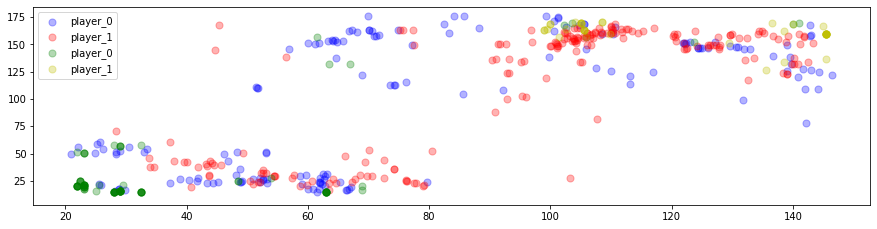

Total game time: 9.58
Winner: Player_0
Player_0: P
Player_1: Z


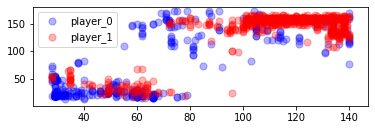

Total game time: 9.58
Winner: Player_0
Player_0: P
Player_1: Z


In [0]:
plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plot_rightclick(train2, 888)
plt.subplot(2,1,2)
plot_camera(train2, 888)

In [0]:
def selection_process(df):
  df = df[(df['event']=='Selection')&(df['event_contents'].notnull())][["game_id","player","event_contents"]]
  df["player_ability_code"] = [re.sub('\[.*?\]','',item) for item in df['event_contents'].str.strip('[]').str.replace('\'','')]
  df["player_ability_code"][df["player_ability_code"].isnull()] = "Other"

  play , select_list = {}, []
  for select0 in df["player_ability_code"]:
    sell = select0.replace(' ','').split(',')
    for se in sell:
      if (se=='')|(se=='None'):
        continue
      try: play[se]+= 1
      except: 
        play[se]=1
        select_list.append(se)  
  play = pd.DataFrame(play)
  # play = play[play<1000].index
  # df["player_ability_code"][df["player_ability_code"].str.contains('|'.join(df_g_down))] = "Other"
  return play, select_list

In [0]:
play , select_list = selection_process(train2)
play

In [17]:
sorted(play.items(), key=(lambda x : x[1]), reverse= True)

[('SCV', 5822121),
 ('Drone', 4562348),
 ('Egg', 3599693),
 ('Probe', 3483606),
 ('Zergling', 1141131),
 ('Marine', 825262),
 ('OrbitalCommand', 387047),
 ('BanelingCocoon', 383055),
 ('Queen', 332624),
 ('Barracks', 307815),
 ('WarpGate', 275393),
 ('Nexus', 270708),
 ('Hatchery', 235303),
 ('Lair', 187851),
 ('Factory', 168117),
 ('Overlord', 129920),
 ('Stalker', 126866),
 ('SupplyDepotLowered', 120361),
 ('Adept', 117881),
 ('Roach', 116210),
 ('Hive', 108143),
 ('Reaper', 99258),
 ('Baneling', 98022),
 ('Hellion', 94435),
 ('Starport', 93563),
 ('Medivac', 63287),
 ('MULE', 60341),
 ('FungalGrowthMissile', 59317),
 ('Zealot', 59247),
 ('CreepTumorBurrowed', 58185),
 ('Ravager', 58091),
 ('SpawningPool', 48494),
 ('SupplyDepot', 43678),
 ('Rocks2x2NonConjoined', 43102),
 ('CyberneticsCore', 39693),
 ('SiegeTank', 35423),
 ('Larva', 34429),
 ('Marauder', 32427),
 ('Overseer', 30902),
 ('Stargate', 29015),
 ('RoboticsFacility', 28132),
 ('OrbitalCommandFlying', 25721),
 ('BarracksTec

In [0]:
def plot_category_hist(data, category,tar):
    plt.figure(figsize=(12,5))
    plt.subplot(2,1,1)
    sns.distplot(data[(data[category] == tar)&(data["win"]==False)]["count"])
    plt.subplot(2,1,2)
    sns.distplot(data[(data[category] == tar)&(data["win"]==True)]["count"])
    plt.legend(data[category].unique())

In [0]:
event_right = train[train.event=="Right Click"][["game_id","event_contents","player"]].reset_index(drop=True)
event_right["event_target"] = ""
event_right["event_target"] = event_right["event_contents"][event_right["event_contents"].str.split(':',expand=True).iloc[:,0]=="Target"].str.split(':',expand=True).iloc[:,2]
event_right.dropna(axis=0,inplace=True)
event_right.drop("event_contents",axis=1,inplace=True)
event_right

,game_id,player,event_target
7,0,0,"(150.0, 22.5, 49120)"
8,0,1,"(27.5, 154.5, 49120)"
10,0,0,"(140.0, 47.0, 40928)"
12,0,0,"(154.0, 55.5, 40928)"
15,0,1,"(18.0, 147.5, 49120)"
...,...,...,...
11565870,38871,0,"(168.5, 24.5, 49088)"
11565871,38871,0,"(168.5, 24.5, 49088)"
11565872,38871,0,"(168.5, 24.5, 49088)"
11565873,38871,0,"(168.5, 24.5, 49088)"


In [0]:
event_right1.str.split(' ',expand=True).iloc[:,1].value_counts()[:15]

DestructibleSignsConstruction    828419
None                             627809
Assimilator                      129630
Refinery                         125320
Extractor                        121819
DestructibleSignsFunny            82821
Hatchery                          57955
SCV                               57348
Probe                             37647
Drone                             37030
Nexus                             35184
Medivac                           31579
OrbitalCommand                    31076
Bunker                            26967
Pylon                             25948
Name: 1, dtype: int64

In [0]:
# df_0 = event_right.loc[(event_right['player']==0)&(event_right['game_id']==10000)]
# df_1 = event_right.loc[(event_right['player']==1)&(event_right['game_id']==10000)]
df_0 = event_right.loc[(event_right['player']==0)]
df_1 = event_right.loc[(event_right['player']==1)]
right_plot_0 = np.array([item.replace('(', '').replace(')', '').split(',') for item in df_0["event_target"]]).astype(float)
right_plot_1 = np.array([item.replace('(', '').replace(')', '').split(',') for item in df_1["event_target"]]).astype(float)

# plt.scatter(right_plot_0[:, 0], right_plot_0[:, 1], label='player_0', alpha=0.3, color='b', s=50)
# plt.scatter(right_plot_1[:, 0], right_plot_1[:, 1], label='player_1', alpha=0.3, color='r', s=50)
# plt.legend()

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
train_y = df_train["winner"]
train_x = df_train.drop(["winner",'game_id','time'],axis=1)
scaler = StandardScaler()
train_sc = scaler.fit_transform(train_x)
train_sc = pd.DataFrame(train_sc,columns = train_x.columns)
test_x = df_test.drop(["game_id","time"],axis=1)
test_sc = scaler.transform(test_x)
test_sc = pd.DataFrame(test_sc,columns = test_x.columns)
x_train, x_val , y_train, y_val = train_test_split(train_x,train_y,test_size=0.1,shuffle=True)

In [0]:
import lightgbm as lgb
from sklearn import svm, tree, linear_model, neighbors, ensemble, discriminant_analysis
MLA = [
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    linear_model.LogisticRegressionCV(),
    linear_model.RidgeClassifierCV(),
    
    neighbors.KNeighborsClassifier(),
    
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    discriminant_analysis.LinearDiscriminantAnalysis(),

    lgb.LGBMClassifier()
    ]
def lgb_cv(num_leaves, learning_rate, n_estimators, reg_alpha, reg_lambda, min_split_gain, min_child_weight,min_child_samples, colsample_bytree, x_data=None, y_data=None, n_splits=5, output='score'):
    score = 0
    kf = KFold(n_splits=n_splits)
    models = []
    for train_index, valid_index in kf.split(x_data):
        x_train, y_train = x_data.iloc[train_index], y_data[train_index]
        x_valid, y_valid = x_data.iloc[valid_index], y_data[valid_index]
        
        model = lgb.LGBMClassifier(
            num_leaves = int(num_leaves), 
            learning_rate = learning_rate, 
            n_estimators = int(n_estimators), 
            reg_alpha = reg_alpha, 
            reg_lambda = reg_lambda,
            min_split_gain= min_split_gain,
            min_child_weight = min_child_weight,
            min_child_samples = int(min_child_samples),
            colsample_bytree = np.clip(colsample_bytree, 0, 1), 
        )
        
        model.fit(x_train, y_train)
        models.append(model)
        
        pred = model.predict_proba(x_valid)[:, 1]
        true = y_valid
        score += roc_auc_score(true, pred)/n_splits
    
    if output == 'score':
        return score
    if output == 'model':
        return models

In [0]:
from functools import partial 
func_fixed = partial(lgb_cv, x_data=train_sc, y_data=train_y, n_splits=5, output='score')
lgbBO = BayesianOptimization(
    func_fixed, 
    {
        'num_leaves': (50, 150),    
        'learning_rate': (0.0005, 0.01),  
        'n_estimators': (700, 2000),                        
        'reg_alpha': (0.0001, 1),       
        'reg_lambda': (0.0001, 1), 
        'min_split_gain' : (0.001, 0.1),
        'min_child_weight' : (0.001, 0.1),
        'min_child_samples' : (10,25),
        'colsample_bytree': (0.85, 1.0),
    }, 
    random_state=4321            
)
lgbBO.maximize(init_points=5, n_iter=20)

In [0]:
params = lgbBO.max['params']
models = lgb_cv(
    params['num_leaves'], 
    params['learning_rate'], 
    params['n_estimators'], 
    params['reg_alpha'], 
    params['reg_lambda'], 
    params['min_split_gain'], 
    params['min_child_weight'],
    params['min_child_samples'],
    params['colsample_bytree'],
    x_data=train_sc, y_data=train_y, n_splits=10, output='model')
len(models)

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
forest_clf = RandomForestClassifier(n_estimators=700, max_depth=25,min_samples_leaf=3,n_jobs=-1)
forest_scores = cross_val_score(forest_clf, train_x, train_y, cv=5,verbose=100)
forest_scores.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV]  ................................................................
[CV] .................................... , score=0.602, total=  11.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.0s remaining:    0.0s
[CV]  ................................................................
[CV] .................................... , score=0.607, total=   4.3s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.3s remaining:    0.0s
[CV]  ................................................................


KeyboardInterrupt: ignored

In [0]:
forest_clf.fit(x_train,y_train)
y_pred = forest_clf.predict(x_val)
roc_auc_score(y_val,y_pred)

0.5897686445240728

In [0]:
from sklearn.metrics import silhouette_score
pred_train = pd.DataFrame(models[0].predict(train_x),columns=["pred_train"], index = train_y.index)
train_set = pd.concat([train_y, pred_train],axis=1)
false_index = train_set[train_set["winner"]!=train_set["pred_train"]].index

In [117]:
import hdbscan
from sklearn.metrics import silhouette_score
model_db = hdbscan.HDBSCAN( min_cluster_size=5, gen_min_span_tree=True,)
predict = pd.DataFrame(model_db.fit_predict(train_sc.iloc[false_index,:]))

predict.columns=['predict']
print(predict["predict"].value_counts())
silhouette_score(train_sc.iloc[false_index,:], predict)

/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:219: UserWarning: Cannot generate Minimum Spanning Tree; the implemented Prim's does not produce the full minimum spanning tree 
  'the full minimum spanning tree ', UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-1     10334
 33     5577
 24       24
 26       21
 31       17
 14       17
 34       16
 7        13
 6        12
 13       12
 5        11
 17       11
 19       10
 21        9
 20        9
 11        7
 29        7
 25        7
 10        6
 9         6
 12        6
 23        6
 15        6
 32        6
 2         6
 22        6
 8         5
 16        5
 1         5
 28        5
 30        5
 18        5
 3         5
 27        5
 4         5
 0         5
Name: predict, dtype: int64


-0.11797034070367524

In [0]:
preds = []
for model in models:
    pred = model.predict(test_x)
    preds.append(pred)
pred = np.mean(preds, axis=0)
test_index = []
winner_test = []
for i,j in enumerate(pred):
  if (j==0)|(j==1):
    test_index.append(i)
    if j==0:
      winner_test.append(0)
    else:
      winner_test.append(1)
train_x1 = pd.concat([train_x,test_x.iloc[test_index,:] ],axis=0,sort=False)


In [0]:
winner = pd.concat([train_y,pd.Series(winner_test)],sort=False).reset_index(drop=True)

In [53]:
func_fixed1 = partial(lgb_cv, x_data=train_x1, y_data=winner, n_splits=5, output='score')
lgbB1 = BayesianOptimization(
    func_fixed1, 
    {
        'num_leaves': (50, 150),    
        'learning_rate': (0.0005, 0.01),  
        'n_estimators': (500, 2000),      
        'subsample': (0.9, 1.0),            
        'colsample_bytree': (0.9, 1.0),      
        'reg_alpha': (0.0001, 1),       
        'reg_lambda': (0.0001, 1), 
    }, 
    random_state=4321            
)
lgbB1.maximize(init_points=5, n_iter=30)

|   iter    |  target   | colsam... | learni... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.7369   |  0.9071   |  0.008243 |  1.652e+0 |  78.64    |  0.1932   |  0.9789   |  0.9406   |
|  2        |  0.7214   |  0.9758   |  0.001347 |  964.8    |  111.9    |  0.46     |  0.2184   |  0.9664   |
|  3        |  0.7367   |  0.9679   |  0.009528 |  921.9    |  112.0    |  0.3834   |  0.4004   |  0.9943   |
|  4        |  0.7366   |  0.993    |  0.00951  |  1.063e+0 |  84.23    |  0.6648   |  0.04242  |  0.9232   |
|  5        |  0.7267   |  0.943    |  0.00124  |  1.65e+03 |  135.4    |  0.1505   |  0.1012   |  0.9271   |
|  6        |  0.7191   |  0.9622   |  0.003353 |  501.9    |  50.1     |  0.8005   |  0.6114   |  0.9473   |
|  7        |  0.7356   |  0.9838   |  0.009143 |  1.998e+0 |  146.9    |  0.3685   |  0.3504   |  0.9575   |
|  8      

In [0]:
params1 = lgbB1.max['params']
models1 = lgb_cv(
    params1['num_leaves'], 
    params1['learning_rate'], 
    params1['n_estimators'], 
    params1['subsample'], 
    params1['colsample_bytree'], 
    params1['reg_alpha'], 
    params1['reg_lambda'], 
    x_data=train_x1, y_data=winner, n_splits=8, output='model')

In [79]:
preds = []
for model in models1:
    pred = model.predict_proba(test_x)[:,1]
    preds.append(pred)
pred = np.mean(preds, axis=0)

sample = pd.read_csv("/gdrive/My Drive/Data/sample_submission.csv", index_col=0)
sample['winner'] = sample['winner'] + pred
sample.to_csv('/gdrive/My Drive/Data/sample1.csv')
sample.head()

,winner
game_id,
38872,0.632264
38873,0.422786
38874,0.322260
38875,0.378548
38876,0.689303


In [80]:
preds

[array([0.61272382, 0.36600486, 0.28731241, ..., 0.75409011, 0.54952914,
        0.60546574]),
 array([0.619768  , 0.47567415, 0.3903367 , ..., 0.82968621, 0.57479886,
        0.66993448]),
 array([0.71762608, 0.46385061, 0.32121937, ..., 0.7482121 , 0.65453542,
        0.65844709]),
 array([0.64651618, 0.41226548, 0.26697027, ..., 0.75809613, 0.63446741,
        0.75067906]),
 array([0.6389178 , 0.34003813, 0.26986098, ..., 0.79495565, 0.56514528,
        0.70092405]),
 array([0.59814474, 0.38305787, 0.36375035, ..., 0.73514222, 0.59217523,
        0.61638111]),
 array([0.59090971, 0.45422055, 0.32598439, ..., 0.77137112, 0.57877677,
        0.69110404]),
 array([0.6335035 , 0.487176  , 0.35264293, ..., 0.745365  , 0.6009777 ,
        0.61855947])]